## Crawl tweets by API

In [1]:
# ! pip install tqdm
# ! pip install tweepy
# ! pip install torch
# ! pip install transformers
# ! pip install emoji

In [ ]:
# https://github.com/twitterdev/Twitter-API-v2-sample-code/blob/main/Tweet-Lookup/get_tweets_with_bearer_token.py
import requests
import json
import time
from tqdm import tqdm

# To set your bearer token:
bearer_token = "AAAAAAAAAAAAAAAAAAAAAGdZbgEAAAAAlXMiIg%2F96Ygnv%2FmvFDMsWb6LuSw%3DPTSIRz5g0G9RaB9pxp8QhdTtHxXnhEZsjLkpNyqQBR8EfRy8WS"


def create_url(ids):
    tweet_fields = "tweet.fields=attachments,author_id,context_annotations,conversation_id,created_at,entities,geo,id,in_reply_to_user_id,lang,public_metrics,possibly_sensitive,referenced_tweets,reply_settings,source,text,withheld"
    # Tweet fields are adjustable.
    # Options include:
    # attachments, author_id, context_annotations,
    # conversation_id, created_at, entities, geo, id,
    # in_reply_to_user_id, lang, non_public_metrics, organic_metrics,
    # possibly_sensitive, promoted_metrics, public_metrics, referenced_tweets,
    # source, text, and withheld
    ids = "ids=" + ids
    # print(ids)
    # You can adjust ids to include a single Tweets.
    # Or you can add to up to 100 comma-separated IDs
    url = "https://api.twitter.com/2/tweets?{}&{}".format(ids, tweet_fields)
    return url


def bearer_oauth(r):
    """
    Method required by bearer token authentication.
    """
    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2TweetLookupPython"
    return r


def connect_to_endpoint(url):
    response = requests.request("GET", url, auth=bearer_oauth)
    # print(response.status_code)
    if response.status_code != 200:
        raise Exception(
            "Request returned an error: {} {}".format(
                response.status_code, response.text
            )
        )
    return response.json()


def crawl_and_save(f_in, f_out):
    train_id_list = []
    for l in f_in.readlines():
        train_id_list.extend(l.strip().split(","))
    start_id = 0
    end_id = start_id + 100
    train_id_len = len(train_id_list)
    # max 100 tweet
    split_crawl = []
    while start_id < train_id_len:
        split_crawl.append(",".join(train_id_list[start_id:end_id]))
        start_id = end_id
        end_id = start_id + 100

    crawl_count = 0
    for ids in tqdm(split_crawl):
        url = create_url(ids)
        json_response = connect_to_endpoint(url)
        for x in json_response["data"]:
            json.dump(x, open(f_out + str(x["id"]) + ".json", "w"))
        crawl_count += 1
        if crawl_count % 290 == 0:
            time.sleep(790)

# un-comment to crawl tweets
def main():
    print("crawl the train tweets")
    #crawl_and_save(open("data/train.data.txt", "r"), "data/train_tweet/")
    # print("crawl the dev tweets")
    # crawl_and_save(open("data/dev.data.txt", "r"), "data/dev_tweet/")
    # print("crawl the analysis tweets")
    # crawl_and_save(open("data/covid.data.txt", "r"), "data/analysis_tweet/")
    print("Finished!")

if __name__ == "__main__":
    main()


## Dataset read-in

Read-in tweets and labels, then sort one tweet with retweets by time

In [1]:
import os
import json
train_ids = open("data/train.data.txt", "r")
train_labels = open("data/train.label.txt", "r")
dev_ids = open("data/dev.data.txt", "r")
dev_labels = open("data/dev.label.txt", "r")



def read_ids_labels(train_ids, train_labels, path = "data/train_tweet/"):
    train_data = []
    train_y = []
    for train_ids_str, label in zip(train_ids.readlines(), train_labels.readlines()):
        train_ids_list = train_ids_str.strip().split(",")
        temp_json_list = []
        if os.path.exists(path + train_ids_list[0] + ".json"):
            for train_id in train_ids_list:
                train_path = path + train_id + ".json"
                if os.path.exists(train_path):
                    tweet_json = json.load(open(train_path, "r"))
                    if tweet_json not in temp_json_list:
                        temp_json_list.append(tweet_json)
                    # while tweet json has reference tweets, keep adding them to the list
                    while "referenced_tweets" in tweet_json:
                        referenced_tweets_id = tweet_json["referenced_tweets"][0]["id"]
                        if os.path.exists(path + referenced_tweets_id + ".json"):
                            tweet_json = json.load(open(path + referenced_tweets_id + ".json", "r"))
                            if tweet_json not in temp_json_list:
                                temp_json_list.append(tweet_json)
                        else:
                            break

            # sort the list by time
            temp_json_list = sorted(temp_json_list, key=lambda x: x["created_at"])
            train_data.append(temp_json_list)
            train_y.append(label)
    return train_data, train_y

train_set, train_label = read_ids_labels(train_ids, train_labels)
dev_set, dev_label = read_ids_labels(dev_ids, dev_labels, path="data/dev_tweet/")
print("Finished!")

Finished!


In [2]:
test_ids = open("data/test.data.txt", "r")
test_set = []
for test_ids_str in test_ids.readlines():
    test_ids_list = test_ids_str.strip().split(",")
    temp_json_list = []
    for test_id in test_ids_list:
        test_path = "data/tweet-objects/" + test_id + ".json"
        if os.path.exists(test_path):
            tweet_json = json.load(open(test_path, "r"))
            if tweet_json not in temp_json_list:
                temp_json_list.append(tweet_json)
            # while tweet json has in_reply_to_status_id, keep adding them to the list
            while tweet_json["in_reply_to_status_id"] != None:
                in_reply_to_status_id = str(tweet_json["in_reply_to_status_id"])
                if os.path.exists("data/tweet-objects/" + in_reply_to_status_id + ".json"):
                    tweet_json = json.load(open("data/tweet-objects/" + in_reply_to_status_id + ".json", "r"))
                    if tweet_json not in temp_json_list:
                        temp_json_list.append(tweet_json)
                else:
                    break
    temp_json_list = sorted(temp_json_list, key=lambda x: x["created_at"])
    test_set.append(temp_json_list)
print("Finished!")

Finished!


## 绘制树结构

In [3]:
record=train_set[0]

index2tweetid=dict()
tweetid2index=dict()

nodes=[]
edges=[]

for i,tweet in enumerate(record):
    index2tweetid[i]=tweet['id']
    tweetid2index[tweet['id']]=i

for i,tweet in enumerate(record):
    nodes.append(i)
    if 'referenced_tweets' in tweet.keys():
        source=i
        target=tweetid2index[tweet['referenced_tweets'][0]['id']]
        edges.append((source,target))

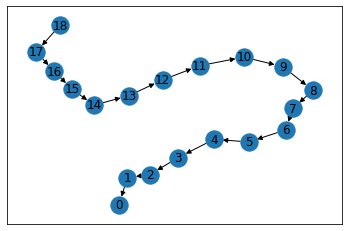

In [5]:
import networkx as nx

tree = nx.DiGraph()
tree.add_nodes_from(nodes)
tree.add_edges_from(edges)

nx.draw_networkx(tree)

In [6]:
# attention: some data may contain multiple trees处理思路:
# 遍历所有tweet，构建出多个树，只保留o(根节点)所在的树 

def build_tree_from_record(record):
    """
    # 基于一条数据(包含多条tweet)，获取到
    *树中的边信息
    * 下标到原始tweet id的映射
    *原始tweet id到下标的映射
    """
    edges = [] 
    nodes = set()
    index2id = dict() # 下标 ->原始id 
    id2index = dict() # 原始id -> 下标 
    id2raw = dict()
    
    for i, tweet in enumerate(record):# 扫描一条数据下的所有tweet
            #记录下标和idstr之间的对应关系 
        id2index[tweet['id']] = i 
        index2id[i] = tweet['id'] 
        id2raw[tweet['id']] = tweet

    index2treeid = {0:0}  #节点下标 ->树id
    parent2children = dict()  #父节点->孩子节点集合

                 
    def recursive_color(node_index):
        treeid = index2treeid[node_index]
#         print(f"treeid: {treeid}")
        if node_index in parent2children:  #当前节点有孩子
            # for child in parent2children[node_index]: 
                # index2treeidichild1=treeid  #子节点与父节点tree id一致
            for child in parent2children[node_index]:
                if child not in index2treeid or index2treeid[child] != treeid:
                    index2treeid[child] = treeid
                    recursive_color(child)

                    
    child2parent=dict()   #子节点指向父节点 
    for i,tweet in enumerate(record):
        #记录边信息
        if 'referenced_tweets' in tweet.keys():
            #父节点原始id
            parent_id = tweet['referenced_tweets'][0].get('id',-1)
            #父节点下标(可能为空)
            parent_index=id2index.get(parent_id,-1)

            if parent_index != -1: #可以找到父节点
                child2parent[i] = parent_index

                #将当前节点放入父节点的孩子集合中
                if parent_index not in parent2children:
                    parent2children[parent_index]=set() 
                parent2children[parent_index].add(i)

                #如果父节点已经有树，递归将所有底层节点设置为同一棵树 
                if parent_index in index2treeid:
                    recursive_color(parent_index) 
                else: #否则新建一颗树(只有两个节点)
                    tree_id = len(index2treeid) 
                    index2treeid[i] = tree_id
                    index2treeid[parent_index] = tree_id
            else:
            #print(f"节点{id2index[tweet['id_str']]}:无法找到父节点") 
                pass
            
    # 提取出tree_id为0的节点和边信息
    for node_index, tree_id in index2treeid.items():
        if tree_id == 0:
            nodes.add(node_index)
            if node_index in child2parent:
                edges.append([node_index, child2parent[node_index]])
    
    return nodes, edges, index2id, id2index, index2treeid, id2raw, parent2children

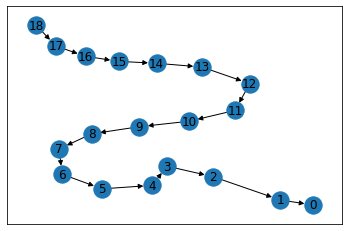

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

result = build_tree_from_record(train_set[0])
result[-1]
nodes=result[0]
edges=result[1]

tree = nx.DiGraph()
tree.add_nodes_from(nodes)
tree.add_edges_from(edges)

nx.draw_networkx(tree)
plt.show(tree)

## pytorch model

In [10]:
import torch
from torch import nn

In [11]:
def computation_order(parent2children):
    order = []
    queue = [0]
    while len(queue) > 0:
        head = queue.pop(0)
        if head in parent2children:
            children = parent2children[head]
            order.append(list(children)+[head])
            queue.extend(children)
    if len(order) < 1:
        order.append([0])
    return list(reversed(order))

In [12]:
class RecursiveTreeUnit(nn.Module):
    def __init__(self, input_dim, memory_dim):
        super().__init__()
        self.input_dim = input_dim
        self.memory_dim = memory_dim
        self.E = nn.Linear(input_dim, memory_dim)
        self.Wr = nn.Linear(memory_dim, memory_dim)
        self.Ur = nn.Linear(memory_dim, memory_dim)
        self.Wz = nn.Linear(memory_dim, memory_dim)
        self.Uz = nn.Linear(memory_dim, memory_dim)
        self.Wh = nn.Linear(memory_dim, memory_dim)
        self.Uh = nn.Linear(memory_dim, memory_dim)

    def forward(self, current_node, child_nodes):
        x_j_tilde = self.E(current_node)
        processed_child_nodes = []
        for i, child_node in enumerate(child_nodes):
            if child_node.size()[1] == self.input_dim:
                x_tilde = self.E(child_node)
                rj = torch.sigmoid(self.Wr(x_tilde))
                zj = torch.sigmoid(self.Wz(x_tilde))
                hj_tilde = torch.tanh(self.Wh(x_tilde))
                hj = zj * hj_tilde
                processed_child_nodes.append(hj)
            elif child_node.size()[1] == self.memory_dim:
                processed_child_nodes.append(child_node)

        if len(child_nodes) > 1:
            h_S = torch.stack(processed_child_nodes).squeeze().sum(dim=0)
            if len(h_S.size()) < 2:
                h_S = h_S.unsqueeze(0)
        else:
            h_S = processed_child_nodes[0]

        r_j = torch.sigmoid(self.Wr(x_j_tilde) + self.Ur(h_S))
        z_j = torch.sigmoid(self.Wz(x_j_tilde) + self.Uz(h_S))
        h_j_tilde = torch.tanh(self.Wh(x_j_tilde) + self.Uh(r_j * h_S))
        h_j = (1-z_j) * h_S + z_j * h_j_tilde

        return h_j

In [ ]:
class RecursiveTree(nn.Module):
    def __init__(self, input_dim, memory_dim):
        super().__init__()
        self.input_dim = input_dim
        self.memory_dim = memory_dim
        self.tree_unit = RecursiveTreeUnit(input_dim, memory_dim)
        self.classifier = nn.Linear(memory_dim, 2)

    def forward(self, order, index2vec):
        for seq in order:
            current = seq[-1]
            children = seq[:-1]
            child_vecs = []
            for child in children:
                if child in encoded_node_vecs:
                    child_vec = encoded_node_vecs[child]
                else:
                    child_vec = index2vec[child]
                child_vecs.append(child_vec)
            current_vec = index2vec[current]
            encoded_node_vec = self.tree_unit(current_vec, child_vecs)
            encoded_node_vecs[current] = encoded_node_vec
        tree_vec = encoded_node_vecs[0]
        logits = self.classifier(tree_vec)
        return logits